# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 5. Сегментация изображений

### Практическое задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ


2. Обучить модель на выбор из segmentation_models_pytorch

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/nWMoBVgvWYcI7g

### Решение

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import cv2

import torch

from torch.utils.data import Dataset 
from torch.utils.data import DataLoader 

import segmentation_models_pytorch as smp

from segmentation_models_pytorch import utils
from segmentation_models_pytorch.encoders import get_preprocessing_fn

C:\Users\SergeyZ06\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\SergeyZ06\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\SergeyZ06\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


#### Настройки проекта

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Путь к данным.
PATH__DATA = r'data/'
PATH__FILES = r'data/720p/'
PATH__MASKS = r'data/mask/'

# Глобальные настройки случаного семени.
GLOBAL__RANDOM_STATE = 0

#### 1. Подготовка данных

In [3]:
# Загрузка датасета.
df = pd.read_csv(PATH__DATA + r'list.csv')

In [4]:
# Проверка: вывод первых пяти строк.
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [5]:
# Проверка: существуют ли все маски.
df['mask'] = df['mask'].apply(lambda x: x if os.path.exists(PATH__MASKS + x) else None)

In [6]:
# Вывод информации о размерности датасета.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28594 non-null  object
 1   width     28594 non-null  int64 
 2   height    28594 non-null  int64 
 3   class     28594 non-null  object
 4   xmin      28594 non-null  int64 
 5   ymin      28594 non-null  int64 
 6   xmax      28594 non-null  int64 
 7   ymax      28594 non-null  int64 
 8   mask      28540 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


In [7]:
# Удаление пропусков.
df = df.dropna()

In [8]:
# Вывод информации о размерности датасета.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28540 entries, 0 to 28593
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   width     28540 non-null  int64 
 2   height    28540 non-null  int64 
 3   class     28540 non-null  object
 4   xmin      28540 non-null  int64 
 5   ymin      28540 non-null  int64 
 6   xmax      28540 non-null  int64 
 7   ymax      28540 non-null  int64 
 8   mask      28540 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.2+ MB


In [9]:
# Класс датасета.
class DatasetLips(Dataset):
    def __init__(self, df, preprocessing=None):
        self.df = df
        
        self.images = df['filename']
        self.masks = df['mask']
        
        self.preprocessing = preprocessing
    
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(PATH__FILES + self.images[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (320, 192))
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img) / 255.0
        
        img = img.permute(2, 0, 1)
        
        mask = cv2.cvtColor(cv2.imread(PATH__MASKS + self.masks[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (320, 192))
        mask = torch.as_tensor(mask, dtype=torch.uint8) / 255
        mask = mask.permute(2, 0, 1)
        mask = mask[1, :, :]
        
        return (img.float(), mask)
    
    
    def __len__(self):
        return len(self.df)

In [10]:
# Инициализация датасета.
ds = DatasetLips(df)

In [11]:
# Проверка: вывод длины датасета.
ds.__len__()

28540

In [12]:
# Загрузка первого объекта датасета и его маски.
img_test, mask_test = ds.__getitem__(0)

# Вывод размерностей.
img_test.shape, mask_test.shape

(torch.Size([3, 192, 320]), torch.Size([192, 320]))

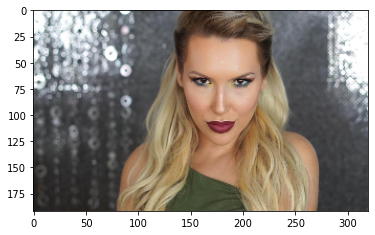

In [13]:
# Проверка: отрисовка объекта.
plt.imshow(img_test.permute(1, 2, 0));

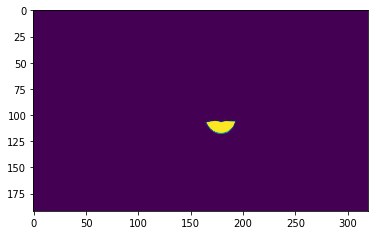

In [14]:
# Проверка: отрисовка маски.
# plt.imshow(mask_test.permute(1, 2, 0));
plt.imshow(mask_test.permute(0, 1));

In [15]:
# Разбиение данных на обучающую и тестовую выборки в соотношении 70:30 соответственно.
X_train, X_test = train_test_split(df, test_size=0.3, random_state=GLOBAL__RANDOM_STATE)

# Сброс индексов.
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Представление выборок в виде датасетов.
ds_train = DatasetLips(X_train)
ds_test = DatasetLips(X_test)

In [16]:
# Загрузчик обучающих данных.
dl_train = DataLoader(
    ds_train,
#     batch_size=8,
    batch_size=32,
    shuffle=True
)

# Загрузчик тестовых данных.
dl_test = DataLoader(
    ds_test,
#     batch_size=4,
    batch_size=16,
    shuffle=False
)

torch.Size([32, 3, 192, 320]) torch.Size([32, 192, 320])
tensor(0.) tensor(0.9765)
tensor(0.) tensor(1.)


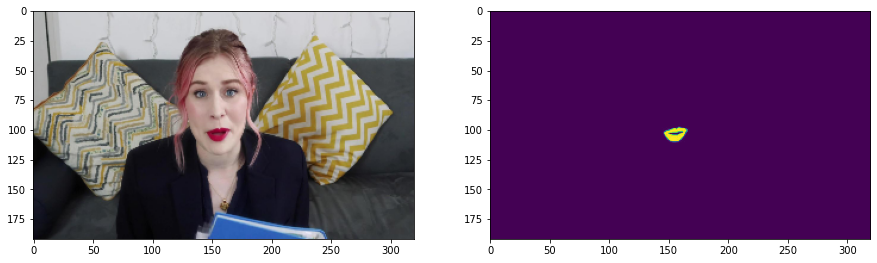

In [17]:
# Проверка: отрисовка изображения и маски из загрузчика.
for img, target in dl_train:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
#     ax[1].imshow(target[0].permute(1, 2, 0))
    ax[1].imshow(target[0])
    break

#### 2. Построение модели

In [18]:
# Инициализация предобученной модели "resnet18" для одного класса.
model = smp.Unet('resnet18', encoder_weights='imagenet', classes=1, activation='softmax')

In [19]:
# DEVICE = 'cuda'

# Фукнция потерь Dice.
loss = smp.utils.losses.DiceLoss()

# Метрика качества Intersection over Union.
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# Метод оптимизации Adam.
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [20]:
# Эпоха обучения.
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
#     device=DEVICE,
    verbose=True,
)

# Эпоха валидации.
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
#     device=DEVICE,
    verbose=True,
)

In [21]:
%%time


# Обучение и валидация модели на одной эпохе.
for i in range(0, 1):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(dl_train)
    valid_logs = valid_epoch.run(dl_test)


Epoch: 0
train:   0%|                                                                                                                                                                              | 0/625 [00:00<?, ?it/s]

C:\Users\SergeyZ06\AppData\Local\Programs\Python\Python310\lib\site-packages\segmentation_models_pytorch\base\modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [11:56<00:00,  1.34s/it, dice_loss - 0.8437, iou_score - 0.08621]
CPU times: total: 8h 12min 10s
Wall time: 1h 10min 40s


In [22]:
# Сохранение модели.
# torch.save(model, 'model.pth')

In [23]:
# Загрузка модели.
# model = torch.load('model.pth')

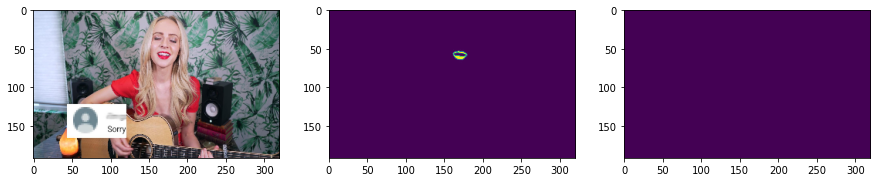

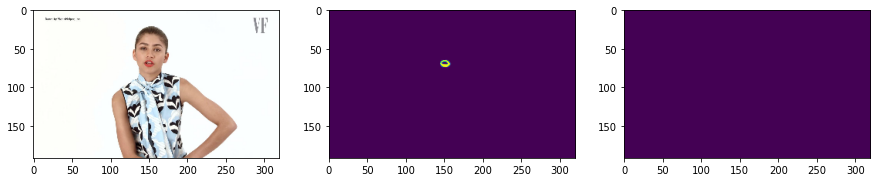

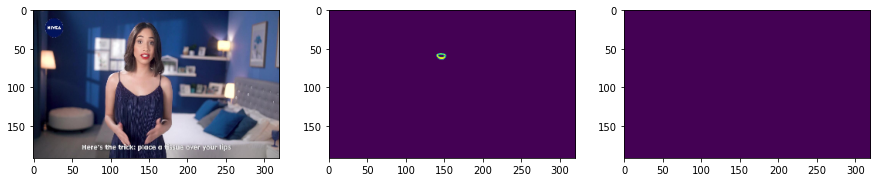

In [69]:
# Проверка: отрисовка изображения, маски и предсказанной маски.
i = 0

for img, target in dl_test:
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0])
    
    output = model.predict(img)
    ax[2].imshow(output[0].permute(1, 2, 0))
    
    i += 1
    
    if i == 3:
        break

Не смотря на долгое время обучения, более часа, модель посредственно справилась с задачей.

Метрика качества на тестовой выборке <code>iou_score - 0.08621</code>, что говорит о корректных прогнозах на грани случайности.